Построение модели классификации

Обзор обучающего датасета
Обработка выбросов
Обработка пропусков

Анализ данных
Отбор признаков
Балансировка классов

Подбор моделей, получение бейзлана
Выбор наилучшей модели, настройка гиперпараметров
Проверка качества, борьба с переобучением
Интерпретация результатов
Прогнозирование на тестовом датасете

Выполнить для тестового датасета те же этапы обработки и постронияния признаков
Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
Соблюдать исходный порядок примеров из тестового датасета

In [283]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [284]:
import warnings
warnings.simplefilter('ignore')

In [285]:
train_path = '/home/polmura/GeekBrains/Python_libs_2/course_project/course_project_train.csv'
test_path = '/home/polmura/GeekBrains/Python_libs_2/course_project/course_project_test.csv'

In [286]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

# Данные

In [171]:
df_train = pd.read_csv(train_path)
features = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
        'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Default']
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Размерность датасета**

df_train.shape

**Количественные признаки**

df_train.describe()

**Целевая переменная**

In [140]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Тестовый датасет**

df_test = pd.read_csv(test_path)
df_test.info()

df_test.shape

**Номинативные признаки**

In [201]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

In [349]:
df_train = pd.read_csv(train_path)
features = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
        'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Default']

# Пропуски

In [350]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].median()
df_train.loc[df_train['Years in current job'].isnull(), 
             'Years in current job'] = '10+ years'

**Приведение номинативных признаков**

In [352]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                      0
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    df_train[colname] = df_train[colname].astype(str)

In [328]:
df_train['Home Ownership'] = df_train['Home Ownership'].replace({'Home Mortgage':0, 'Rent':1, 'Own Home':2, 'Have Mortgage':3})
df_train['Years in current job'] = df_train['Years in current job'].replace({'10+ years':0, '2 years':1, 
            '3 years':2, '< 1 year':3, '5 years':4, '1 year':5, '4 years':6, '6 years':7, 
            '7 years':8, '8 years':9, '9 years':10})
df_train['Term'] = df_train['Term'].replace({'Short Term':0, 'Long Term':1})
df_train['Purpose'] = df_train['Purpose'].replace({'debt consolidation':0, 'other':1, 
            'home improvements':2, 'business loan':3, 'medical bills':4, 'major purchase':5, 'take a trip':6, 
            'buy house':7, 'small business':8, 'wedding':9, 'moving':10, 'educational expenses':11, 
                                                   'vacation':12, 'renewable energy':13, 'buy a car':14})


In [229]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,2,482087.0,0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,0,0,99999999.0,47386.0,7914.0,749.0,0
1,2,1025487.0,0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,0,1,264968.0,394972.0,18373.0,737.0,1
2,0,751412.0,9,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,0,0,99999999.0,308389.0,13651.0,742.0,0
3,2,805068.0,7,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,0,0,121396.0,95855.0,11338.0,694.0,0
4,1,776264.0,9,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,0,0,125840.0,93309.0,7180.0,719.0,0


**Обработка ID**

In [351]:
df_train['ID'] = df_train.index.tolist()

df_train.info()

for num_colname in df_train.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(df_train[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

# **Выбросы**

df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = df_train['Current Loan Amount'].median()
#Результат не улучшает

# **Выделение целевой переменной и отбор признаков**

In [232]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = ['Credit Default', 'Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems',
'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Months since last delinquent', 'Bankruptcies']
NEW_FEATURE_NAMES = ['Home Ownership', 'Annual Income', 'Years in current job', 'Number of Open Accounts', 
'Years of Credit History', 'Maximum Open Credit', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Default']
#NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

**Корреляция**

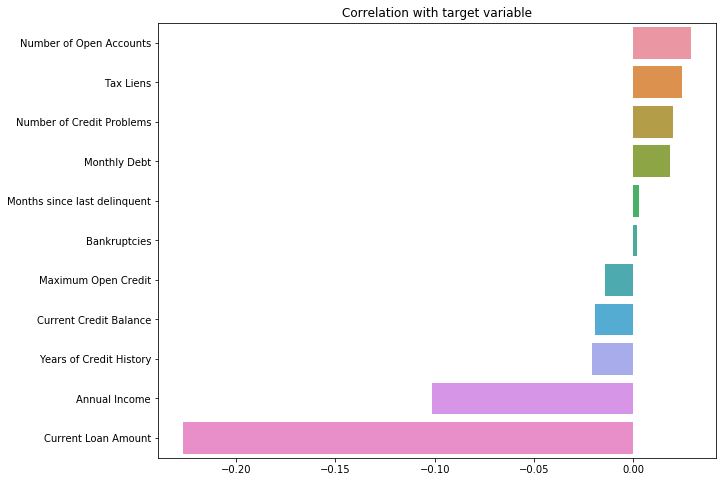

In [25]:
corr_with_target = df_train[FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

'Months since last delinquent', 'Bankruptcies' - не включаем в новый список фич

**Оценка номинативных признаков в разрезе целевой переменной**

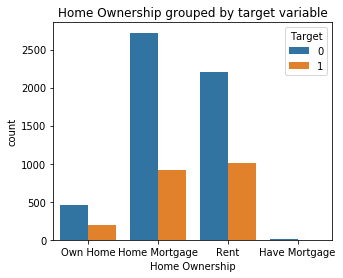

In [23]:
plt.figure(figsize=(5, 4))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df_train)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

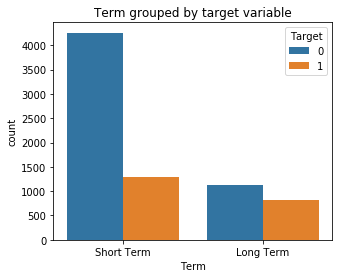

In [33]:
plt.figure(figsize=(5, 4))

sns.countplot(x="Term", hue=TARGET_NAME, data=df_train)
plt.title('Term grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

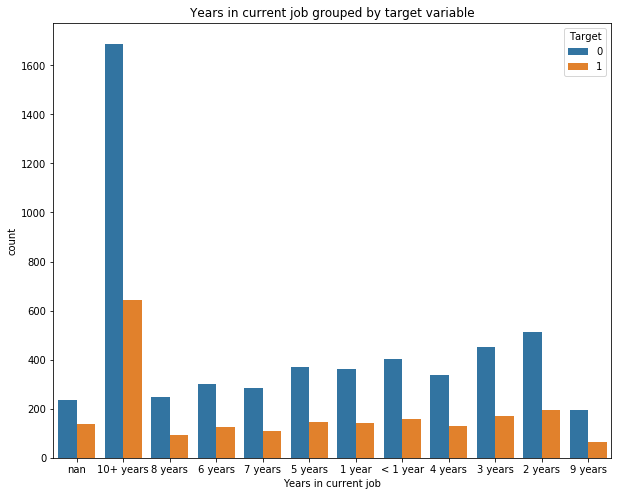

In [64]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

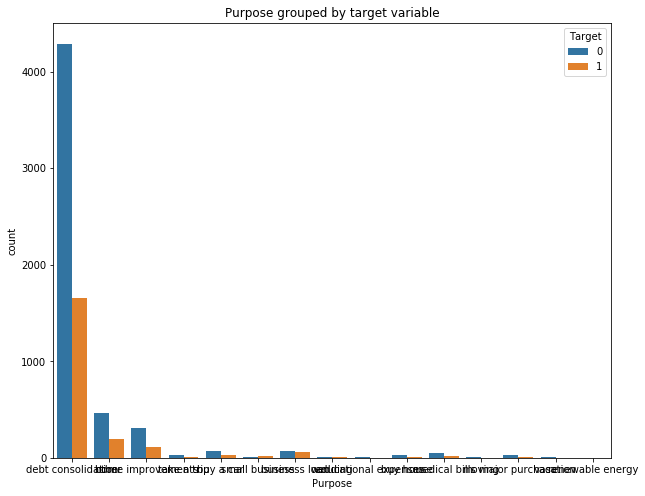

In [65]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Пока номинативные оставим как есть. Вернемся к ним если не будет хватать точности

**Количественные переменные**

df_train['Current Loan Amount'].value_counts()

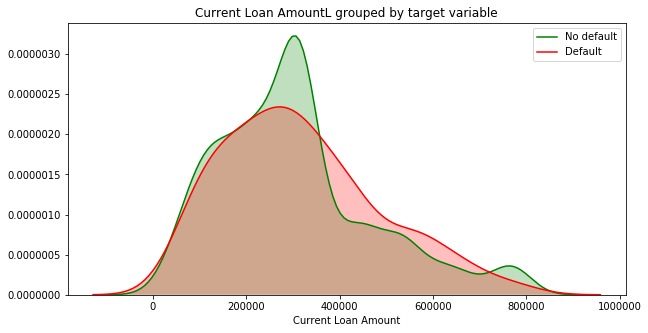

In [73]:
limit_bal_with_target_s = df_train[['Current Loan Amount', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Current Loan Amount']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan AmountL grouped by target variable')
plt.show()

/home/polmura/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/polmura/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Current Loan AmountL grouped by target variable')

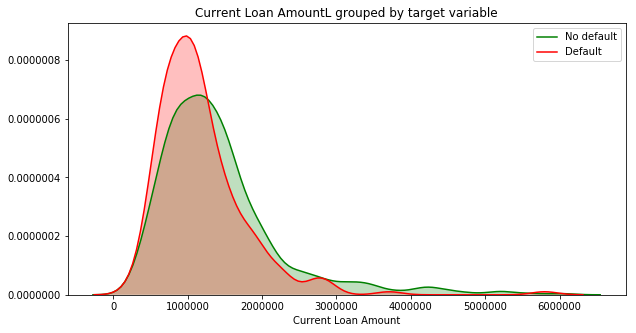

In [83]:
limit_bal_with_target_s = df_train[['Annual Income', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Annual Income']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan AmountL grouped by target variable')

Text(0.5, 1.0, 'Current Loan AmountL grouped by target variable')

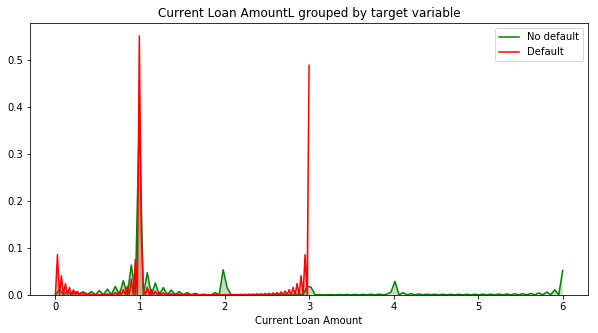

In [84]:
limit_bal_with_target_s = df_train[['Tax Liens', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Tax Liens']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan AmountL grouped by target variable')

**Tax Liens выглядит некрасиво. Удаляем**

Text(0.5, 1.0, 'Current Loan AmountL grouped by target variable')

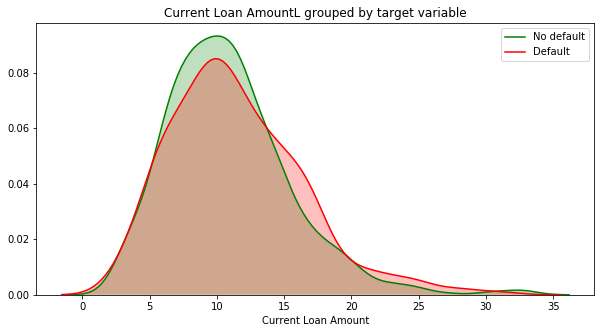

In [86]:
limit_bal_with_target_s = df_train[['Number of Open Accounts', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Number of Open Accounts']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan AmountL grouped by target variable')

Text(0.5, 1.0, 'Current Loan AmountL grouped by target variable')

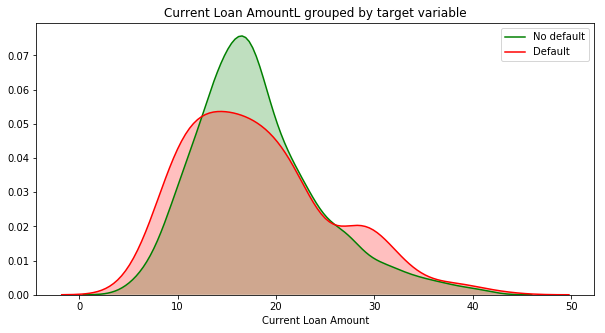

In [87]:
limit_bal_with_target_s = df_train[['Years of Credit History', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Years of Credit History']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan AmountL grouped by target variable')

Text(0.5, 1.0, 'Current Loan AmountL grouped by target variable')

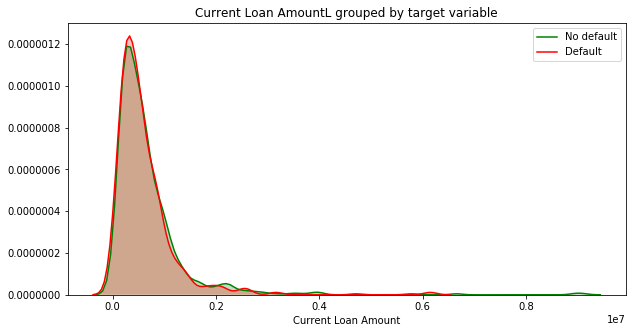

In [88]:
limit_bal_with_target_s = df_train[['Maximum Open Credit', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Maximum Open Credit']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan AmountL grouped by target variable')

Text(0.5, 1.0, 'Current Loan AmountL grouped by target variable')

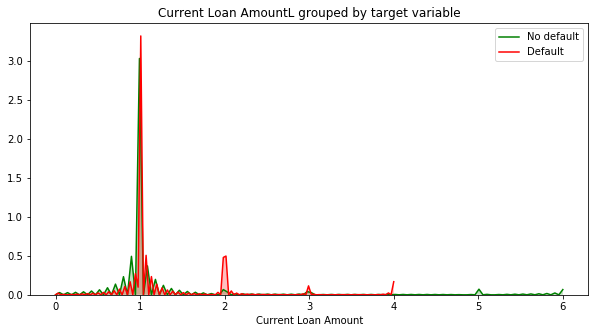

In [89]:
limit_bal_with_target_s = df_train[['Number of Credit Problems', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Number of Credit Problems']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan AmountL grouped by target variable')

In [93]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

**так же как Tax Liens, выглядит бесполезным**

Text(0.5, 1.0, 'Current Loan AmountL grouped by target variable')

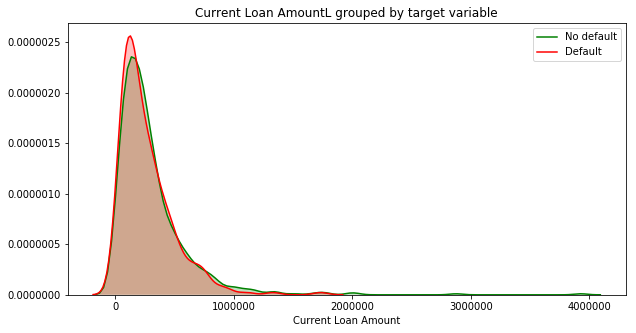

In [91]:
limit_bal_with_target_s = df_train[['Current Credit Balance', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Current Credit Balance']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan AmountL grouped by target variable')

Text(0.5, 1.0, 'Current Loan AmountL grouped by target variable')

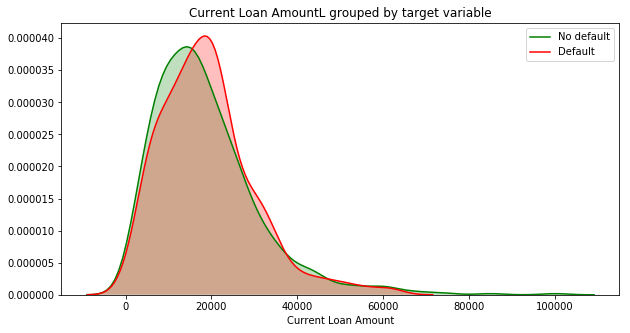

In [92]:
limit_bal_with_target_s = df_train[['Monthly Debt', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Monthly Debt']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan AmountL grouped by target variable')

# Анализ признакового пространства

**Матрица корреляций**

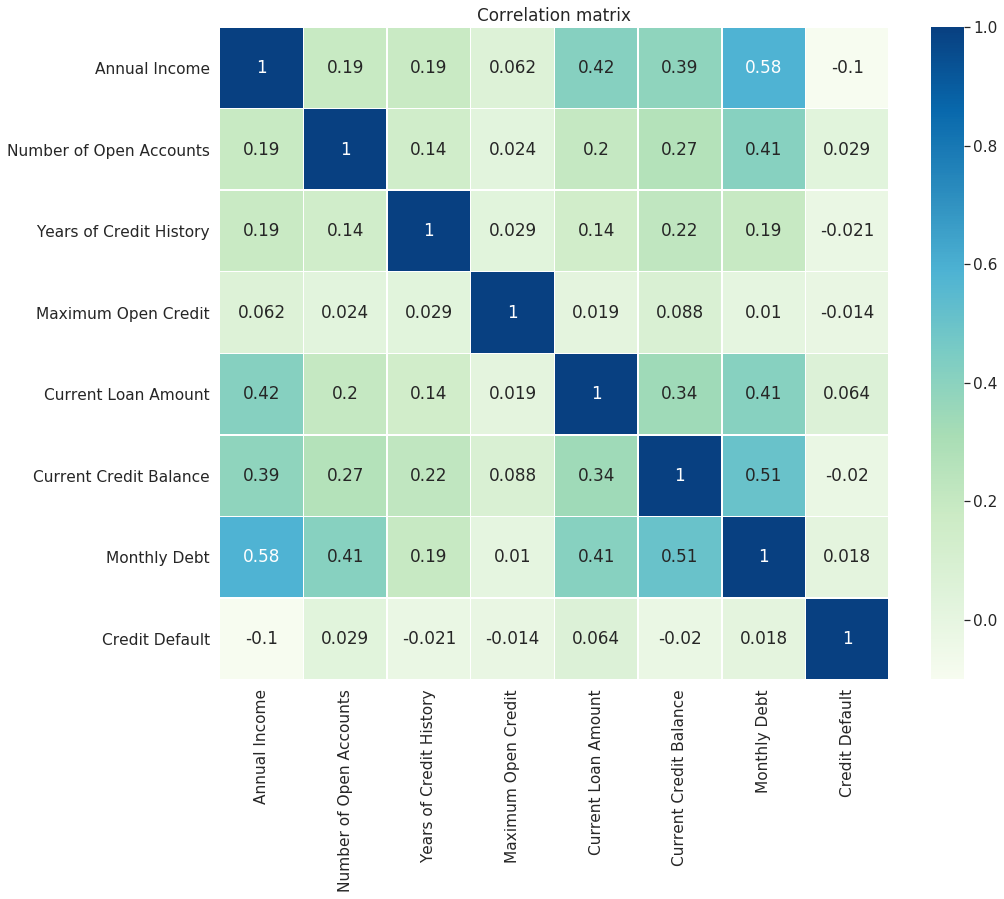

In [102]:
plt.figure(figsize = (15,12))

sns.set(font_scale=1.4)
sns.heatmap(df_train[NEW_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

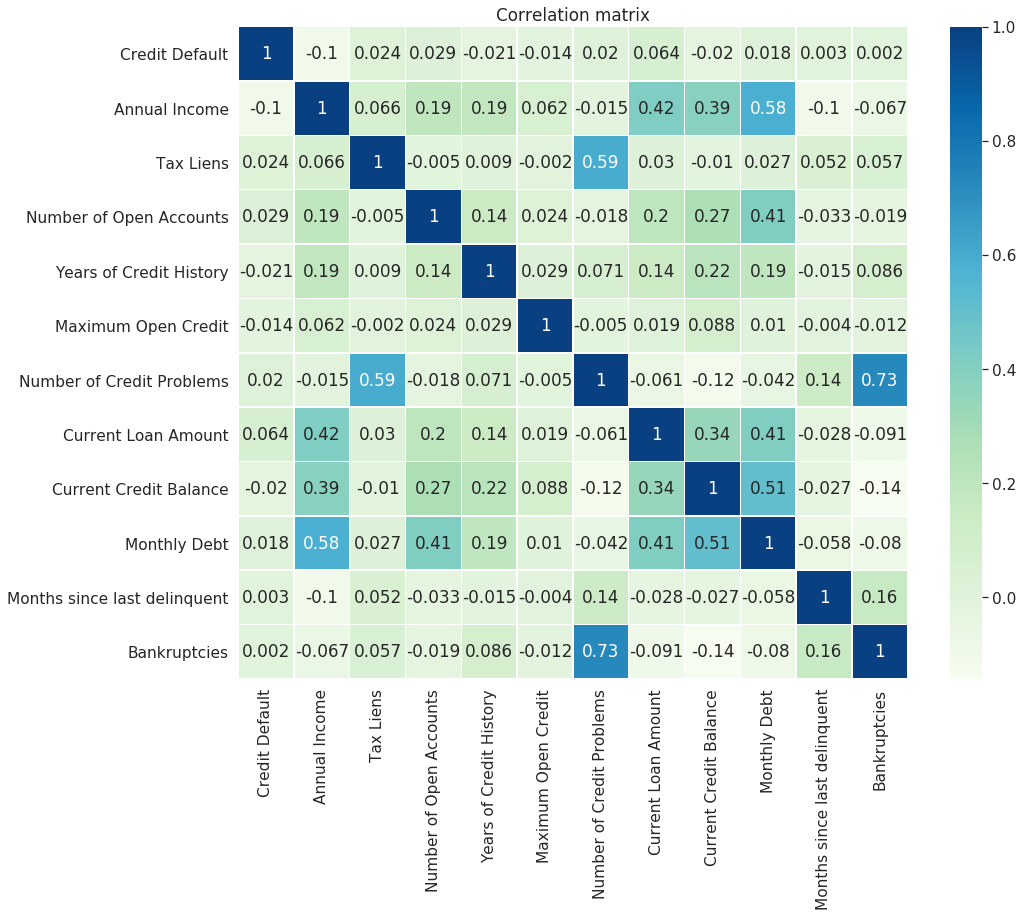

In [103]:
plt.figure(figsize = (15,12))

sns.set(font_scale=1.4)
sns.heatmap(df_train[FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# Упаковка данных

In [341]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES 

In [306]:
NUM_FEATURE_NAMES = ['Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES 

**Приведение типов для CatBoost**

for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

**Нормализация**

In [343]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

In [320]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null category
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null category
Term                            7500 non-null category
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default             

**train/test**

In [344]:
X = df_norm[SELECTED_FEATURE_NAMES]
y = df_norm[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

**Балансировка**

In [345]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

df_balanced[TARGET_NAME].value_counts()

X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

0    3771
1    2958
Name: Credit Default, dtype: int64

# Построение и оценка базовых моделей

In [301]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [347]:
model_lgbm = lgbm.LGBMClassifier(n_estimators = 300, max_depth = 2, random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      3771
           1       0.69      0.65      0.67      2958

   micro avg       0.71      0.71      0.71      6729
   macro avg       0.71      0.71      0.71      6729
weighted avg       0.71      0.71      0.71      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1616
           1       0.45      0.56      0.50       634

   micro avg       0.69      0.69      0.69      2250
   macro avg       0.63      0.65      0.64      2250
weighted avg       0.71      0.69      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1185  431
1                277  357


model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

# Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [235]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)

**Подбор гиперпараметров**

In [236]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [237]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [245]:
%%time

rs = RandomizedSearchCV(model_lgbm, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)
#GridSearch попробовать

CPU times: user 2.14 s, sys: 35.6 ms, total: 2.18 s
Wall time: 20.5 s


In [247]:
%%time

rs = GridSearchCV(model_lgbm, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 4.26 s, sys: 74.4 ms, total: 4.34 s
Wall time: 47.3 s


In [252]:
print(type(rs))

NameError: name 'rs' is not defined

In [282]:
rs.best_params_

NameError: name 'rs' is not defined